In [31]:
import sys

# Set the sys path to the main directory of the project
MAIN_DICT = "/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability"
sys.path.append(MAIN_DICT)

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn

from utils.load import load_data
from utils.params import set_param

from sklearn.preprocessing import MinMaxScaler

BATCH_SIZE = 32

# Set torch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


In [48]:
# exp = 'b726'
# exp = 'b698'
# exp = 'i417'
# exp = 'p4679'
exp = "p4581"
# exp = 'cascadia'
# exp = 'sim_b726'
# exp = 'sim_b698'
# exp = 'sim_i417'

params = set_param(exp)

dirs = {"main": MAIN_DICT}
dirs["data"] = dirs["main"] + "/data/" + params["dir_data"]

X, _, t, _, _ = load_data(exp, dirs, params)

# Put the detrended shear stress (X) and time (t) into a pandas dataframe allows
# us to work with it more easily and carry out downsampling

# In numpy, the shape of an array is a tuple that gives the size of each 
# dimension. The shape `(200010, 1)` means that the array `X` is a 2D array with
# 200010 rows and 1 column. The shape `(200010,)` means that the array `t` is a 
# 1D array with 200010 elements. The trailing comma is used to indicate that 
# this is a tuple with one element. In other words, `t` is a 1D array (like a 
# list), while `X` is a 2D array (like a list of lists, where each inner list 
# has only one element).

print(X.shape)
print(t.shape)

# `t.reshape(-1, 1)` is reshaping the `t` array. The `-1` in reshape function is
# a placeholder for "figure out what the dimension should be based on the length
# of the array and the other dimensions". The `1` means we want `t` to have one
# column. So, `t.reshape(-1, 1)` is reshaping `t` to have one column and as many
# rows as needed to accommodate the data.

# We need to reshape `t` because `np.hstack` requires the arrays of the same 
# dimensions.

# `np.hstack` horizontally stacks multiple arrays. In this case, it's stacking 
# the arrays `X` and `t.reshape(-1, 1)` side by side. The result is a single 2D 
# array where the first columns are from `X` and the last column is from `t`.

# The resulting 2D array is then turned into a pandas DataFrame, which is a 2D 
# labeled data structure with columns of potentially different types.
ts_data = pd.DataFrame(np.hstack((X, t.reshape(-1, 1))), columns=["X", "t"])

ts_data.head()

(200010, 1)
(200010,)


,X,t
0,0.002811,0.000
1,0.002731,0.001
2,0.002231,0.002
3,0.002411,0.003
4,0.002241,0.004


Sample rate: 999.9950002499876 Hz


Text(0, 0.5, 'Shear stress (MPa)')

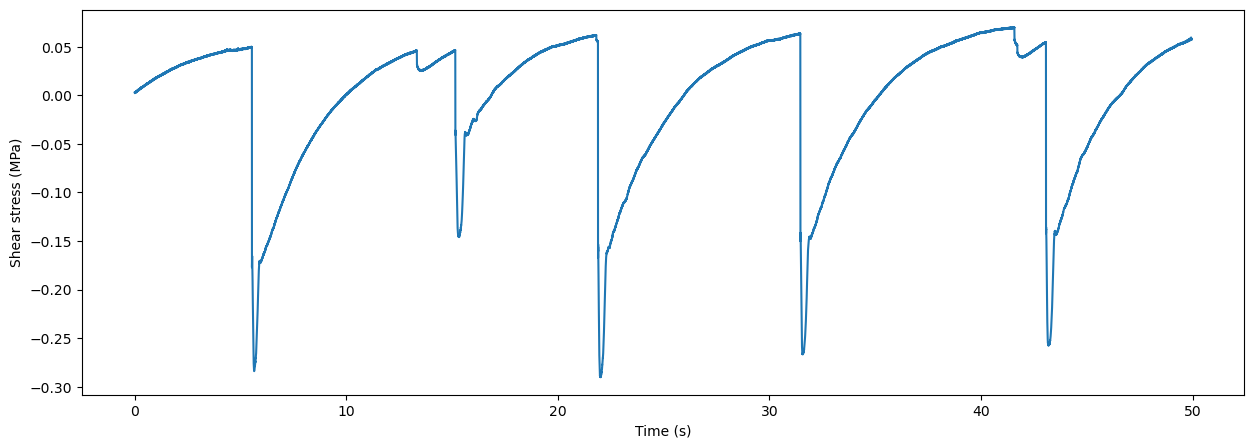

In [50]:
SECONDS_TO_DISPLAY = 50

# Compute the sample rate from the time data
sample_rate = 1 / np.mean(np.diff(ts_data["t"]))
print("Sample rate:", sample_rate, "Hz")

# Sample rate as an interger
sample_rate = int(sample_rate)

segment_in_sec = sample_rate * SECONDS_TO_DISPLAY

plt.figure(figsize=(15, 5))
plt.plot(ts_data["t"][:segment_in_sec], ts_data["X"][:segment_in_sec])
plt.xlabel("Time (s)")
plt.ylabel("Shear stress (MPa)")
plt.title("De-trended shear stress vs time")

# Not plotting derivative and log derivative for now as signal is too noisy at 
# this stage

Sample rate: 9.999950002499878 Hz


Text(0, 0.5, 'Shear stress (MPa)')

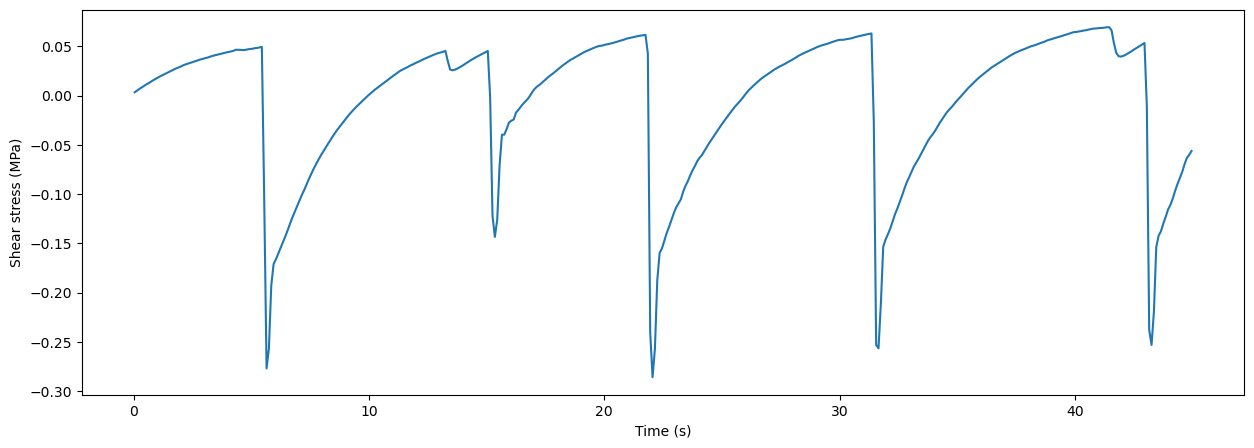

In [51]:
WINDOW = int(1e2) 
STEP = int(1e2)

# Downsample to remove noise (smoothing) and make forecasting easier (less 
# points to predict)
# TODO: What are each of these functions doing?
ts_data = ts_data.rolling(window=WINDOW, step=STEP).mean().dropna()
ts_data = ts_data.reset_index(drop=True)
ts_data = ts_data.dropna()
ts_data.head()

# TODO: Wrap this in a util function
# Compute the sample rate from the time data post downsampling
sample_rate = 1 / np.mean(np.diff(ts_data["t"]))
print("Sample rate:", sample_rate, "Hz")

# Sample rate as an interger
sample_rate = int(sample_rate)

segment_in_sec = sample_rate * SECONDS_TO_DISPLAY

# Plot the downsampled data
plt.figure(figsize=(15, 5))
plt.plot(ts_data["t"][:segment_in_sec], ts_data["X"][:segment_in_sec])
plt.xlabel("Time (s)")
plt.ylabel("Shear stress (MPa)")
plt.title("De-noised de-trended shear stress vs time")

Text(0.5, 1.0, 'Log rate of change of de-noised de-trended shear stress vs time')

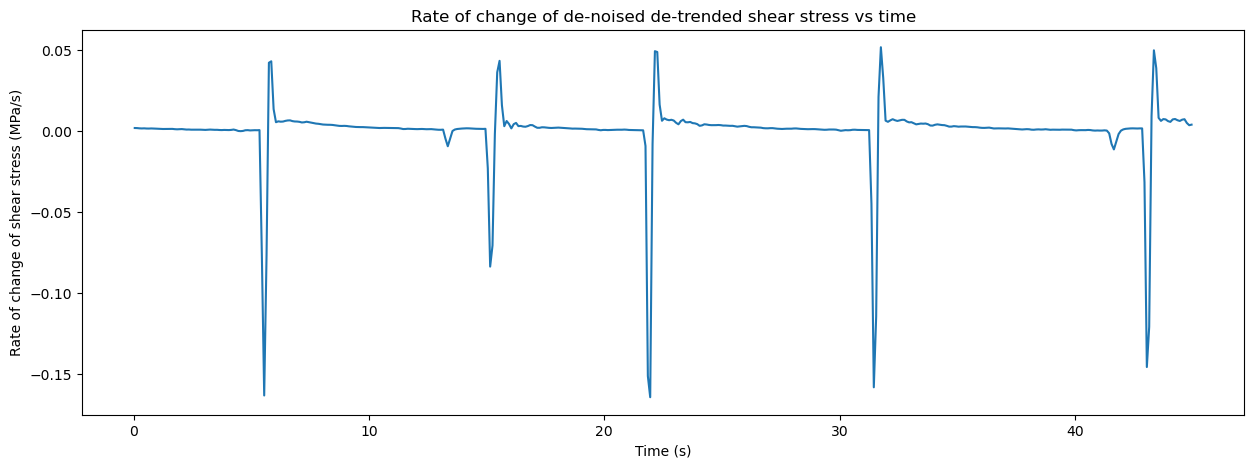

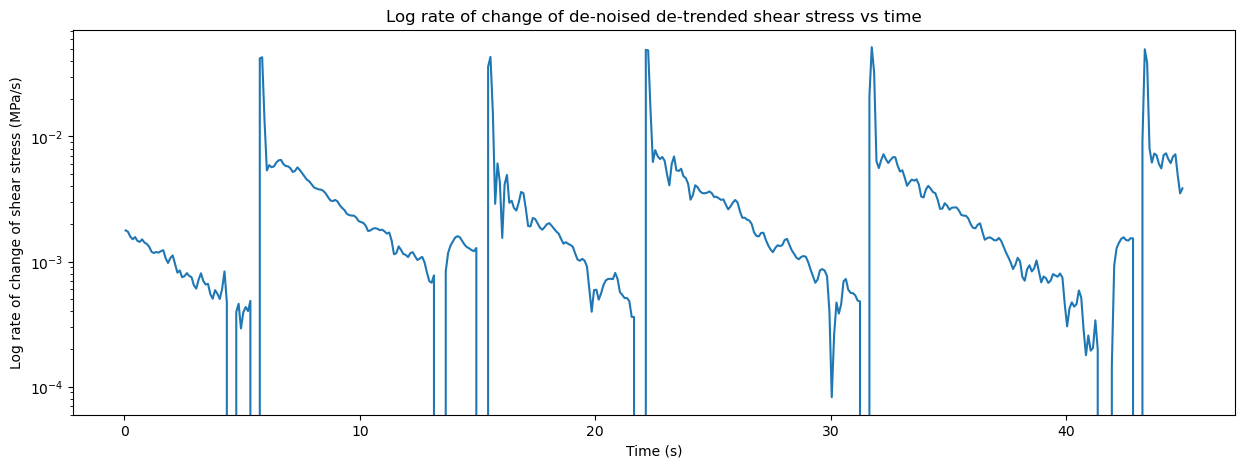

In [52]:
# Analysis of derivative of shear stress

# Plot the derivative of the data (e.g. the rate of change of shear stress)
plt.figure(figsize=(15, 5))
plt.plot(ts_data["t"][:segment_in_sec], np.gradient(ts_data["X"][:segment_in_sec]))
plt.xlabel("Time (s)")
plt.ylabel("Rate of change of shear stress (MPa/s)")
plt.title("Rate of change of de-noised de-trended shear stress vs time")

# Do a similar gradient plot but with a log scale
plt.figure(figsize=(15, 5))
plt.plot(ts_data["t"][:segment_in_sec], np.gradient(ts_data["X"][:segment_in_sec]))
plt.yscale("log")
plt.xlabel("Time (s)")
plt.ylabel("Log rate of change of shear stress (MPa/s)")
plt.title("Log rate of change of de-noised de-trended shear stress vs time")

# When the log rate of change is approximately 10^-3, the system becomes unstable
# Get all the timesteps where the log rate of change is approximately 10^-3
# gradient = np.gradient(ts_data["X"])
# log_gradient = np.log10(np.abs(gradient))

# # Get the indices of the timesteps where the log rate of change is approximately 10^-3
# unstable_indices = np.where(np.logical_and(log_gradient > -3.1, log_gradient < -2.9))[0]

# # Plot the unstable indices on a shear stress vs time plot
# plt.figure(figsize=(15, 5))
# plt.plot(ts_data["t"], ts_data["X"])
# plt.plot(ts_data["t"][unstable_indices], ts_data["X"][unstable_indices], 'r.')
# plt.xlabel("Time (s)")
# plt.ylabel("Shear stress (MPa)")

Text(0.5, 1.0, 'Scaled de-noised de-trended shear stress vs time')

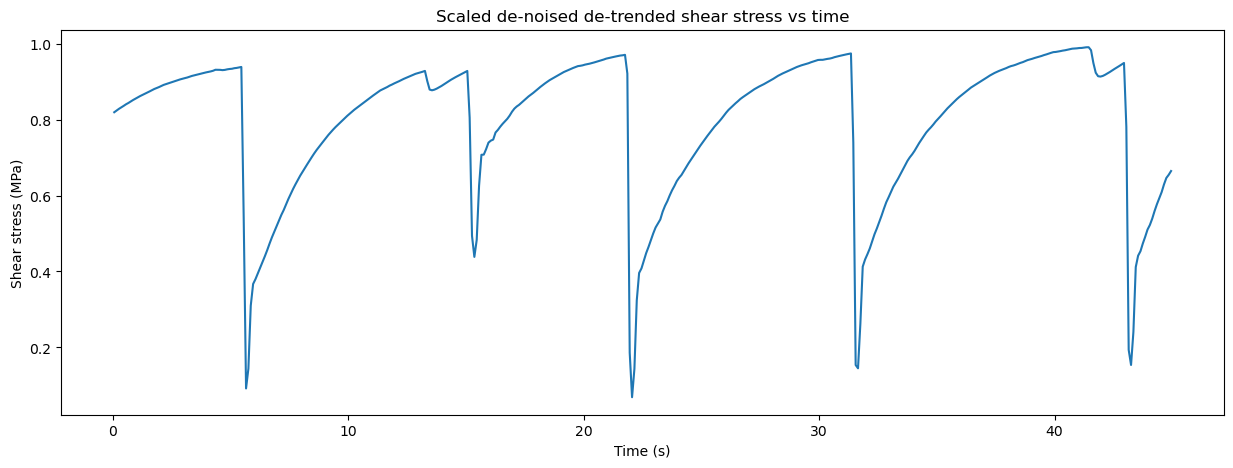

In [73]:
# Do min/max scaling (normalisation) of the shear stress data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(ts_data["X"].values.reshape(-1, 1)).flatten()

# Plot the scaled data
plt.figure(figsize=(15, 5))
plt.plot(ts_data["t"][:segment_in_sec], X_scaled[:segment_in_sec])
plt.xlabel("Time (s)")
plt.ylabel("Shear stress (MPa)")
plt.title("Scaled de-noised de-trended shear stress vs time")

Number of samples: 320
First index: 1061
Last index: 1111
First index: 1887
Last index: 1937
First index: 1567
Last index: 1617
First index: 1236
Last index: 1286
First index: 646
Last index: 696
First index: 1505
Last index: 1555
First index: 1412
Last index: 1462
First index: 85
Last index: 135
First index: 1721
Last index: 1771
First index: 702
Last index: 752
First index: 649
Last index: 699
First index: 459
Last index: 509
First index: 587
Last index: 637
First index: 720
Last index: 770
First index: 525
Last index: 575
First index: 340
Last index: 390
First index: 222
Last index: 272
First index: 1421
Last index: 1471
First index: 516
Last index: 566
First index: 1274
Last index: 1324
First index: 713
Last index: 763
First index: 1785
Last index: 1835
First index: 772
Last index: 822
First index: 477
Last index: 527
First index: 136
Last index: 186
First index: 1424
Last index: 1474
First index: 124
Last index: 174
First index: 1854
Last index: 1904
First index: 52
Last index: 10

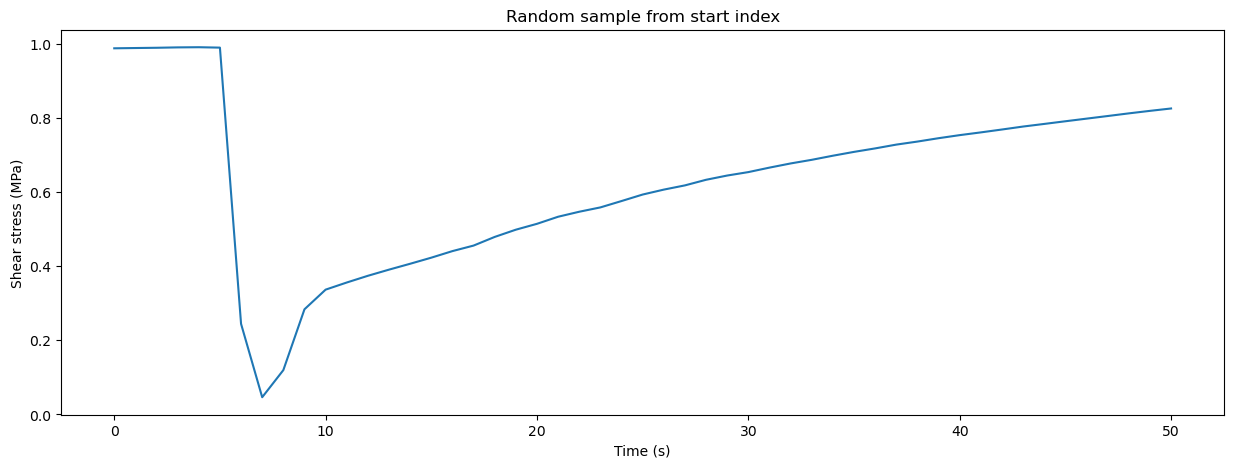

In [84]:
# Generate x and y data for training the model
LOOKBACK = 50
FORECAST = 1
BATCH_SAMPLES = 10 # nb. samples factor of the batch size to fit into batches
TRAIN_SPLIT = 0.8

# Train test sample generation strategy:
# 1. Generate a random start index
# 2. Generate a sample of length LOOKBACK starting from the random start index
# 3. Generate a sample of length FORECAST starting from the random start index + LOOKBACK
# 4. Repeat 1-3 until we have BATCH_SAMPLES samples

# Number of samples sanity check - is there enough data to generate the number 
# of unique samples we want?

samples = BATCH_SIZE * BATCH_SAMPLES

print("Number of samples:", samples)

# Create a array of random start indices of size samples
start_idx = np.random.randint(0, len(X_scaled) - LOOKBACK - FORECAST, size=samples)

# Plot a random section of the sample from the start index
plt.figure(figsize=(15, 5))
plt.plot(X_scaled[start_idx[0] : start_idx[0] + LOOKBACK + FORECAST])
plt.xlabel("Time (s)")
plt.ylabel("Shear stress (MPa)")
plt.title("Random sample from start index")

def create_dataset(X, start_idx, lookback, forecast, train_test_split=0.8):
    """
    Create X_train, y_train and X_test, y_test datasets from X
    X_train is a collection of samples of length lookback
    y_train is a collection of samples of length forecast
    """
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    # Split into train and test sets
    train_size = int(len(start_idx) * train_test_split)
    train_idx = start_idx[:train_size]
    test_idx = start_idx[train_size:]

    # Create X_train and y_train
    for idx in train_idx:
        print("First index:", idx)
        print("Last index:", idx + lookback)
        X_train.append(X[idx : idx + lookback])
        y_train.append(X[idx + lookback : idx + lookback + forecast])

    # Create X_test and y_test
    for idx in test_idx:
        X_test.append(X[idx : idx + lookback])
        y_test.append(X[idx + lookback : idx + lookback + forecast])

    # Convert to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = create_dataset(X_scaled, start_idx, LOOKBACK, FORECAST, TRAIN_SPLIT)

print("Number of training samples:", len(X_train))
print("Number of test samples:", len(X_test))

X_train shape: (256, 50)
[0.67695657 0.69000164 0.7008875  0.71029285 0.72140079 0.73183184
 0.74232394 0.75135994 0.76086061 0.76988752 0.77898586 0.78647849
 0.79286957 0.79923831 0.80452213 0.81006724 0.81647442 0.82463173
 0.83362253 0.84071958 0.84680157 0.85364512 0.86008373 0.86607845
 0.87125889 0.87714374 0.88302936 0.88878149 0.89369595 0.89783224
 0.90172749 0.90571313 0.90994864 0.91376934 0.91770797 0.92148166
 0.92525535 0.92904463 0.93216144 0.93518371 0.93796857 0.94072799
 0.944017   0.94688862 0.94907609 0.95090798 0.95316687 0.95572836
 0.95853037 0.96066667]


Text(0.5, 1.0, 'X and y samples')

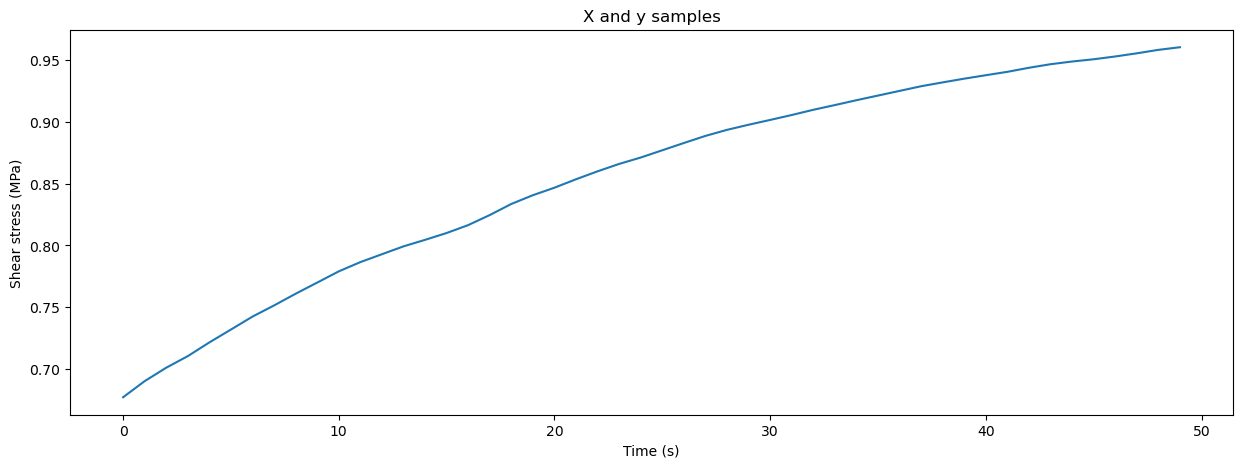

In [76]:

print("X_train shape:", X_train.shape)
print(X_train[0])

# Plot an example X and y sample
plt.figure(figsize=(15, 5))
plt.plot(X_train[0],)
# plt.plot(range(LOOKBACK, LOOKBACK + FORECAST), y_train[0], label="y")
# plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Shear stress (MPa)")
plt.title("X and y samples")

In [50]:
# LSTM model to carry out multi-step forecasting along forecast
# input: [batch size, lookback, 1]
# output: [batch size, forecast, 1]

# Input: batch of samples, each of length lookback
# Output: batch of samples, each of length forecast
# Model: LSTM that takes lookback samples and outputs forecast samples


class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=forecast):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)

        # Fully connected layer
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        # Initialise hidden state and cell state
        h0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size).to(device)
        c0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size).to(device)

        # LSTM layer
        lstm_out, _ = self.lstm(input_seq, (h0, c0))

        # Only take the output from the final timestep
        predictions = self.linear(lstm_out[:, -1, :])

        return predictions

In [51]:
# Train the model
model = LSTM().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 1000
batch_size = 32

for i in range(epochs):
    for j in range(0, len(X_train), batch_size):
        X_batch = X_train[j : j + batch_size]
        y_batch = y_train[j : j + batch_size]

        # Reshape data to (batch_size, lookback, input_size)
        X_batch = torch.Tensor(X_batch.reshape(batch_size, lookback, 1)).to(device)
        y_batch = torch.Tensor(y_batch.reshape(batch_size, forecast, 1)).to(device)

        # Zero out gradients
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(X_batch)

        # Calculate loss
        loss = loss_function(y_pred, y_batch)

        # Backward pass
        loss.backward()
        optimizer.step()

    print(f"epoch: {i:3} loss: {loss.item():10.8f}")

epoch:   0 loss: 0.00689684
epoch:   1 loss: 0.00707096
epoch:   2 loss: 0.00692752
epoch:   3 loss: 0.00701669
epoch:   4 loss: 0.00695444
epoch:   5 loss: 0.00698534
epoch:   6 loss: 0.00697105
epoch:   7 loss: 0.00697347
epoch:   8 loss: 0.00697587


/home/users/ashine/miniconda3/envs/gtc_env/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   9 loss: 0.00697153
epoch:  10 loss: 0.00697565
epoch:  11 loss: 0.00697249
epoch:  12 loss: 0.00697463
epoch:  13 loss: 0.00697344
epoch:  14 loss: 0.00697401
epoch:  15 loss: 0.00697385
epoch:  16 loss: 0.00697379
epoch:  17 loss: 0.00697391
epoch:  18 loss: 0.00697376
epoch:  19 loss: 0.00697386
epoch:  20 loss: 0.00697378
epoch:  21 loss: 0.00697382
epoch:  22 loss: 0.00697379
epoch:  23 loss: 0.00697379


epoch:  24 loss: 0.00697378
epoch:  25 loss: 0.00697377
epoch:  26 loss: 0.00697377
epoch:  27 loss: 0.00697376
epoch:  28 loss: 0.00697375
epoch:  29 loss: 0.00697374
epoch:  30 loss: 0.00697373
epoch:  31 loss: 0.00697372
epoch:  32 loss: 0.00697372
epoch:  33 loss: 0.00697371
epoch:  34 loss: 0.00697370
epoch:  35 loss: 0.00697369
epoch:  36 loss: 0.00697369
epoch:  37 loss: 0.00697368
epoch:  38 loss: 0.00697367
epoch:  39 loss: 0.00697366
epoch:  40 loss: 0.00697365
epoch:  41 loss: 0.00697365
epoch:  42 loss: 0.00697364
epoch:  43 loss: 0.00697363
epoch:  44 loss: 0.00697362
epoch:  45 loss: 0.00697362
epoch:  46 loss: 0.00697361
epoch:  47 loss: 0.00697360
epoch:  48 loss: 0.00697359
epoch:  49 loss: 0.00697359
epoch:  50 loss: 0.00697358
epoch:  51 loss: 0.00697357
epoch:  52 loss: 0.00697357
epoch:  53 loss: 0.00697356
epoch:  54 loss: 0.00697355
epoch:  55 loss: 0.00697354
epoch:  56 loss: 0.00697354
epoch:  57 loss: 0.00697353
epoch:  58 loss: 0.00697352
epoch:  59 loss: 0.0

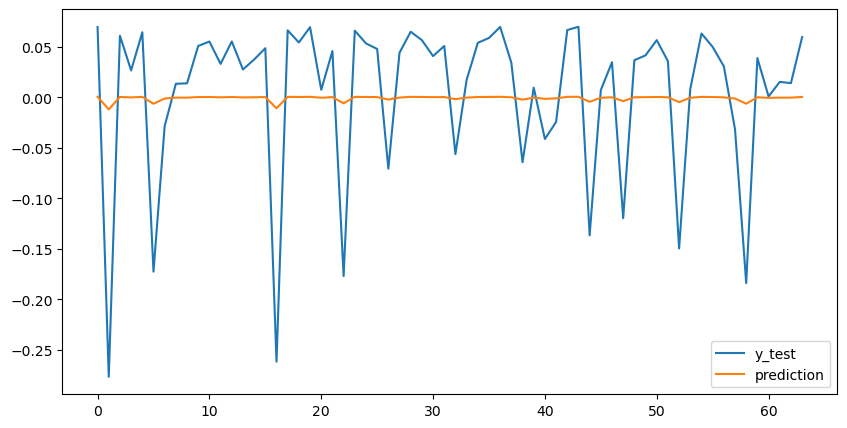

In [52]:
# Do a forward pass on the test set and plot the predictions
with torch.no_grad():
    preds = []
    for i in range(0, len(X_test), batch_size):
        X_batch = X_test[i : i + batch_size]
        X_batch = torch.Tensor(X_batch.reshape(batch_size, lookback, 1)).to(device)
        preds.append(model(X_batch).cpu().numpy())

preds = np.array(preds).flatten()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(y_test.flatten(), label="y_test")
ax.plot(preds, label="prediction")
ax.legend()